In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna
from optuna.trial import TrialState

In [2]:
TRAIN_PATH = "data/train_FD003.txt"
TEST_PATH  = "data/test_FD003.txt"
RUL_PATH   = "data/RUL_FD003.txt"

In [3]:
SEQ_LEN = 80           # window length (you can try 25–50)
STEP = 1                # stride for training windows
BATCH_SIZE = 128
LR = 0.005296227272721275
EPOCHS = 100
PATIENCE = 20
RUL_CLIP = 145         # cap RUL
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [4]:
train_df = pd.read_csv(TRAIN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
test_df  = pd.read_csv(TEST_PATH,  sep=" ", header=None).dropna(axis=1, how="all")
rul_df   = pd.read_csv(RUL_PATH,   sep=" ", header=None)

# consistent columns (first 24 columns typically: unit, cycle, op1..3, s1..21)
cols = ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
train_df = train_df.iloc[:, :len(cols)]
test_df  = test_df.iloc[:, :len(cols)]
train_df.columns = cols
test_df.columns  = cols

In [5]:
train_max = train_df.groupby("unit")["cycle"].max().to_dict()
train_df["RUL"] = train_df.apply(lambda r: train_max[r["unit"]] - r["cycle"], axis=1)
train_df["RUL"] = train_df["RUL"].clip(upper=RUL_CLIP)


In [6]:
rul_vals = rul_df.iloc[:,0].values.flatten()
# rul_vals order is engine 1..N (CMAPSS protocol)
# create a mapping engine -> remaining cycles (RUL_final)
test_rul_map = {unit: int(rval) for unit, rval in zip(sorted(test_df["unit"].unique()), rul_vals)}
# Note: We'll clip later when we construct y_test

In [7]:
selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

In [8]:
train_df = train_df[["unit","cycle"] + selected_features + ["RUL"]]
# test keep features + unit,cycle
test_df = test_df[["unit","cycle"] + selected_features].copy()

# ----------------------------
# 5) Scaling: fit StandardScaler on training features (global)
#    (StandardScaler is preferred here per your guide)
# ----------------------------
scaler = StandardScaler()
train_df[selected_features] = scaler.fit_transform(train_df[selected_features])
test_df[selected_features]  = scaler.transform(test_df[selected_features])

In [9]:
def create_train_sequences(df, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in sorted(df["unit"].unique()):
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        # create windows
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            # label corresponds to last time step of the window (end-1)
            y.append(labels[end-1])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

# Build train sequences for all train units
X_all, y_all = create_train_sequences(train_df, SEQ_LEN, STEP)
print(f"All train sequences: {X_all.shape}, {y_all.shape}")




All train sequences: (16820, 80, 14), (16820,)


In [10]:
units = sorted(train_df["unit"].unique())
n_units = len(units)
# default split: first 80% engines train, rest val (or use fixed 1..80,81..100)
train_units = units[: int(n_units * 0.8)]
val_units   = units[int(n_units * 0.8):]

def create_sequences_by_units(df, units_list, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in units_list:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        for start in range(0, L - seq_len + 1, step):
            end = start + seq_len
            X.append(feats[start:end])
            y.append(labels[end-1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_sequences_by_units(train_df, train_units, SEQ_LEN, STEP)
X_val,   y_val   = create_sequences_by_units(train_df, val_units,   SEQ_LEN, STEP)

print(f"Train: {X_train.shape}, {y_train.shape}   Val: {X_val.shape}, {y_val.shape}")


Train: (13459, 80, 14), (13459,)   Val: (3361, 80, 14), (3361,)


In [11]:
def build_test_last_windows(test_df, rul_map, seq_len=SEQ_LEN):
    X_test = []
    y_test = []
    units_sorted = sorted(test_df["unit"].unique())
    for uid in units_sorted:
        unit_df = test_df[test_df["unit"] == uid].reset_index(drop=True)
        if len(unit_df) < seq_len:
            # pad at start with first row repeated (rare); simpler to skip but we keep padding
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(unit_df[selected_features].iloc[[0]].values, pad_len, axis=0)
            window = np.vstack([pad, unit_df[selected_features].values])
        else:
            window = unit_df[selected_features].values[-seq_len:]
        X_test.append(window.astype(np.float32))
        # RUL for engine = value from rul_map (this is final remaining cycles)
        true_rul = rul_map[uid]
        y_test.append(min(true_rul, RUL_CLIP))  # apply clipping here
    return np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32), units_sorted

X_test, y_test, test_units = build_test_last_windows(test_df, test_rul_map, SEQ_LEN)
print(f"Test windows: {X_test.shape}, Test labels (engines): {y_test.shape}")


Test windows: (100, 80, 14), Test labels (engines): (100,)


In [12]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape [N,1]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SeqDataset(X_train, y_train)
val_ds   = SeqDataset(X_val, y_val)
test_ds  = SeqDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [13]:
class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        out, _ = self.gru(x)          # out shape: (B, T, hidden_dim)
        last = out[:, -1, :]          # take last time-step hidden vector
        return self.fc(last)




In [14]:
## model Training

In [15]:

model = SmallGRU(input_dim=len(selected_features), hidden_dim=32, num_layers=1, dropout=0.1997521681157765).to(DEVICE)


c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1997521681157765 and num_layers=1
  warnings.warn(


In [16]:
criterion = nn.SmoothL1Loss()   # Huber-like loss (more robust)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)



In [17]:
mae_fn = torch.nn.L1Loss()  # MAE function

best_val = float("inf")
wait = 0

train_losses = []
val_losses = []
train_mae_list = []
val_mae_list = []

best_epoch = -1

for epoch in range(1, EPOCHS + 1):
    
    # -----------------------
    # TRAINING
    # -----------------------
    model.train()
    tloss = 0.0
    tmae  = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        tloss += loss.item() * Xb.size(0)
        tmae  += mae_fn(pred, yb).item() * Xb.size(0)

    tloss = tloss / len(train_loader.dataset)
    tmae  = tmae  / len(train_loader.dataset)

    train_losses.append(tloss)
    train_mae_list.append(tmae)

    # -----------------------
    # VALIDATION
    # -----------------------
    model.eval()
    vloss = 0.0
    vmae  = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)

            pred = model(Xb)
            loss = criterion(pred, yb)

            vloss += loss.item() * Xb.size(0)
            vmae  += mae_fn(pred, yb).item() * Xb.size(0)

    vloss = vloss / len(val_loader.dataset)
    vmae  = vmae  / len(val_loader.dataset)

    val_losses.append(vloss)
    val_mae_list.append(vmae)

    # Step LR scheduler using val loss
    scheduler.step(vloss)

    # Display metrics
    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {tloss:.4f} | Val Loss: {vloss:.4f} | "
        f"Train MAE: {tmae:.4f} | Val MAE: {vmae:.4f}"
    )

    # -----------------------
    # EARLY STOPPING
    # -----------------------
    if vloss < best_val - 1e-6:
        best_val = vloss
        best_epoch = epoch
        wait = 0
        torch.save(model.state_dict(), "best_gru_fd003.pth")
        print(f"  -> New best model saved (Val Loss: {best_val:.6f})")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping after {epoch} epochs. Best epoch: {best_epoch}")
            break

# Load best model
model.load_state_dict(torch.load("best_gru_fd003.pth", map_location=DEVICE))


Epoch 001 | Train Loss: 45.5341 | Val Loss: 18.7291 | Train MAE: 46.0289 | Val MAE: 19.2189
  -> New best model saved (Val Loss: 18.729062)
Epoch 002 | Train Loss: 17.3473 | Val Loss: 16.5053 | Train MAE: 17.8383 | Val MAE: 16.9944
  -> New best model saved (Val Loss: 16.505346)
Epoch 003 | Train Loss: 16.0167 | Val Loss: 15.3191 | Train MAE: 16.5056 | Val MAE: 15.8089
  -> New best model saved (Val Loss: 15.319133)
Epoch 004 | Train Loss: 13.8211 | Val Loss: 10.7080 | Train MAE: 14.3082 | Val MAE: 11.1928
  -> New best model saved (Val Loss: 10.707953)
Epoch 005 | Train Loss: 12.3982 | Val Loss: 10.0535 | Train MAE: 12.8854 | Val MAE: 10.5387
  -> New best model saved (Val Loss: 10.053513)
Epoch 006 | Train Loss: 11.7953 | Val Loss: 9.6432 | Train MAE: 12.2818 | Val MAE: 10.1305
  -> New best model saved (Val Loss: 9.643202)
Epoch 007 | Train Loss: 11.2285 | Val Loss: 9.3366 | Train MAE: 11.7144 | Val MAE: 9.8209
  -> New best model saved (Val Loss: 9.336557)
Epoch 008 | Train Loss: 1

<All keys matched successfully>

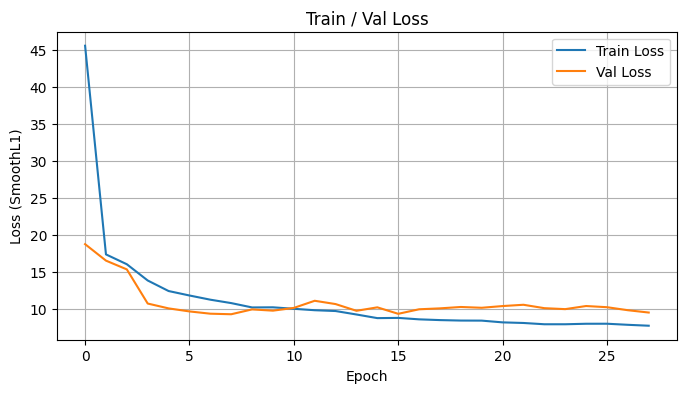

In [18]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (SmoothL1)")
plt.title("Train / Val Loss")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
model.eval()
preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb)                 # shape (batch,1)
        preds.extend(out.cpu().numpy().flatten())

preds = np.array(preds).flatten()
# preds correspond to engines in test_units order
# y_test we built earlier is clipped RUL from rul_map; use that for metric
y_true = y_test.copy()

# compute RMSE (per-engine)
rmse = math.sqrt(mean_squared_error(y_true, preds))
print(f"TEST RMSE (per-engine): {rmse:.6f}")

TEST RMSE (per-engine): 17.003192


In [20]:

print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(test_units, y_true, preds):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}")


Engine | True RUL | Predicted RUL
  1      44.00       49.01
  2      51.00       49.33
  3      27.00       33.43
  4     120.00      150.55
  5     101.00      131.10
  6      99.00      130.57
  7      71.00       57.67
  8      55.00       48.18
  9      55.00       57.37
 10      66.00       64.19
 11      77.00       75.64
 12     115.00       89.92
 13     115.00      110.68
 14      31.00       30.53
 15     108.00      140.41
 16      56.00       86.32
 17     136.00      139.15
 18     132.00      126.44
 19      85.00      115.77
 20      56.00       57.87
 21      18.00       11.56
 22     119.00      111.68
 23      78.00       72.43
 24       9.00        7.24
 25      58.00       53.42
 26      11.00       10.82
 27      88.00      129.13
 28     144.00      133.16
 29     124.00      102.41
 30      89.00       72.54
 31      79.00       71.78
 32      55.00       64.35
 33      71.00       66.09
 34      65.00       85.21
 35      87.00       95.51
 36     137.00      

In [21]:
print("len(y_true):", len(y_true))
print("len(preds):", len(preds))
print("len(test_units):", len(test_units))


len(y_true): 100
len(preds): 100
len(test_units): 100


In [22]:
import torch
import torch.nn as nn

selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

class SmallGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        last = out[:, -1, :]
        return self.fc(last)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SmallGRU(input_dim=len(selected_features), hidden_dim=32, num_layers=1, dropout=0.1997521681157765).to(DEVICE)

model.load_state_dict(torch.load("best_gru_fd003.pth", map_location=DEVICE))

model.eval()

print("Loaded model successfully!")


Loaded model successfully!


c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1997521681157765 and num_layers=1
  warnings.warn(


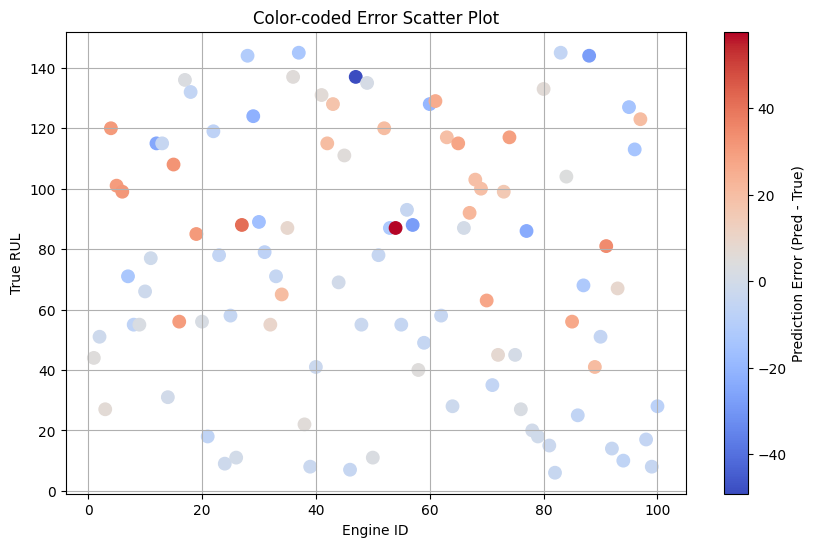

In [23]:
errors = preds - y_true

plt.figure(figsize=(10,6))
plt.scatter(test_units, y_true, c=errors, cmap="coolwarm", s=80)
plt.colorbar(label="Prediction Error (Pred - True)")
plt.xlabel("Engine ID")
plt.ylabel("True RUL")
plt.title("Color-coded Error Scatter Plot")
plt.grid(True)
plt.show()


In [24]:
# %%
import pickle

SCALER_PATH = "scaler_fd003_hyper.pkl"

with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved to:", SCALER_PATH)


Scaler saved to: scaler_fd003_hyper.pkl


In [26]:
# %%
import pickle
import torch

# Load scaler
with open("scaler_fd003_hyper.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

# Load model

model = SmallGRU(input_dim=len(selected_features), hidden_dim=32, num_layers=1, dropout=0.1997521681157765).to(DEVICE)

model.load_state_dict(torch.load("best_gru_fd003.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Model + Scaler loaded successfully.")


Model + Scaler loaded successfully.


In [27]:
# %%
UNSEEN_PATH = "data/test_FD003.txt"
UNSEEN_TRUE_RUL_PATH = "data/RUL_FD003.txt"   # Must contain RUL values line-by-line

# Load unseen dataset
unseen_df = pd.read_csv(UNSEEN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
unseen_df = unseen_df.iloc[:, :len(cols)]
unseen_df.columns = cols

# Keep only features
unseen_df = unseen_df[["unit","cycle"] + selected_features]

# Apply saved scaler
unseen_df[selected_features] = loaded_scaler.transform(unseen_df[selected_features])

print(unseen_df.head())


   unit  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_2  sensor_3  \
0     1      1     -0.764193     -1.377612           0.0 -0.990129 -0.902925   
1     1      2      0.284359     -0.697425           0.0 -0.837172 -0.472693   
2     1      3      0.649073     -1.037519           0.0 -1.487242 -0.924951   
3     1      4      1.241733      0.322855           0.0 -0.493017 -0.521150   
4     1      5     -0.034765      0.322855           0.0  0.004095  0.139616   

   sensor_4  sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  \
0 -0.771639 -0.169846 -0.894321 -0.773819  -1.085443  -0.356616  -0.832566   
1 -0.570063 -0.303673 -0.831142 -0.879925  -1.118768  -0.368904  -0.389857   
2 -1.284277 -0.213485 -0.641607 -0.460003  -0.885488  -0.292104  -0.832566   
3 -0.934332 -0.164028 -0.831142 -0.453997  -0.518905  -0.184586  -0.706078   
4 -0.881124 -0.286218 -0.388893 -0.776822  -1.585329  -0.350472  -0.642833   

   sensor_14  sensor_15  
0  -0.649725  -0.333427 

In [28]:
# %%
def build_unseen_last_windows(df, seq_len=SEQ_LEN):
    X = []
    units_sorted = sorted(df["unit"].unique())
    
    for uid in units_sorted:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(unit_df[selected_features].iloc[[0]].values, pad_len, axis=0)
            window = np.vstack([pad, unit_df[selected_features].values])
        else:
            window = unit_df[selected_features].values[-seq_len:]
            
        X.append(window.astype(np.float32))
        
    return np.array(X, dtype=np.float32), units_sorted

X_unseen, unseen_units = build_unseen_last_windows(unseen_df, SEQ_LEN)
print("X_unseen shape:", X_unseen.shape)


X_unseen shape: (100, 80, 14)


In [29]:
# %%
true_rul_vals = np.loadtxt(UNSEEN_TRUE_RUL_PATH)
y_unseen = true_rul_vals.astype(np.float32)

print("Loaded true RUL shape:", y_unseen.shape)


Loaded true RUL shape: (100,)


In [30]:
# %%
X_unseen_tensor = torch.tensor(X_unseen, dtype=torch.float32).to(DEVICE)

preds_unseen = []
with torch.no_grad():
    out = model(X_unseen_tensor)
    preds_unseen = out.cpu().numpy().flatten()

preds_unseen = np.array(preds_unseen)


In [31]:
# %%
print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(unseen_units, y_unseen, preds_unseen):
    print(f"{u:3d}    {t:7.2f}     {p:7.2f}")

rmse_unseen = math.sqrt(mean_squared_error(y_unseen, preds_unseen))
print("\nUNSEEN DATA RMSE:", rmse_unseen)



Engine | True RUL | Predicted RUL
  1      44.00       49.01
  2      51.00       49.33
  3      27.00       33.43
  4     120.00      150.55
  5     101.00      131.10
  6      99.00      130.57
  7      71.00       57.67
  8      55.00       48.18
  9      55.00       57.37
 10      66.00       64.19
 11      77.00       75.64
 12     115.00       89.92
 13     115.00      110.68
 14      31.00       30.53
 15     108.00      140.41
 16      56.00       86.32
 17     136.00      139.15
 18     132.00      126.44
 19      85.00      115.77
 20      56.00       57.87
 21      18.00       11.56
 22     119.00      111.68
 23      78.00       72.43
 24       9.00        7.24
 25      58.00       53.42
 26      11.00       10.82
 27      88.00      129.13
 28     144.00      133.16
 29     124.00      102.41
 30      89.00       72.54
 31      79.00       71.78
 32      55.00       64.35
 33      71.00       66.09
 34      65.00       85.21
 35      87.00       95.51
 36     137.00      

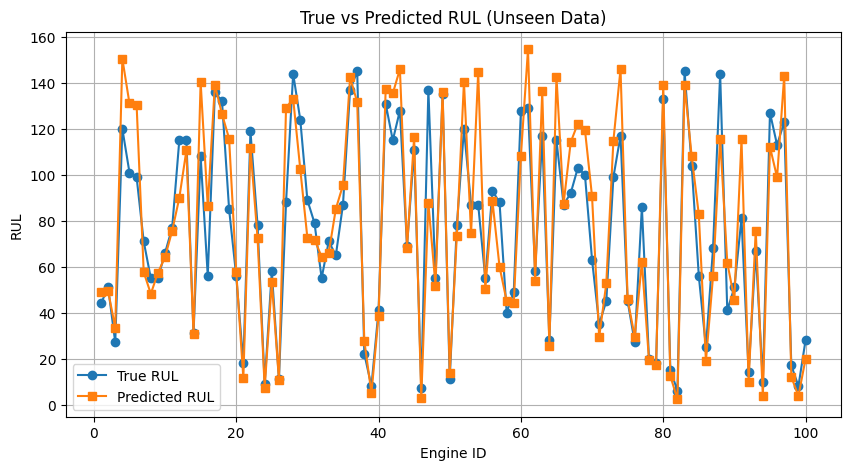

In [32]:
# %%
plt.figure(figsize=(10,5))
plt.plot(unseen_units, y_unseen, marker='o', label="True RUL")
plt.plot(unseen_units, preds_unseen, marker='s', label="Predicted RUL")

plt.title("True vs Predicted RUL (Unseen Data)")
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()
plt.show()


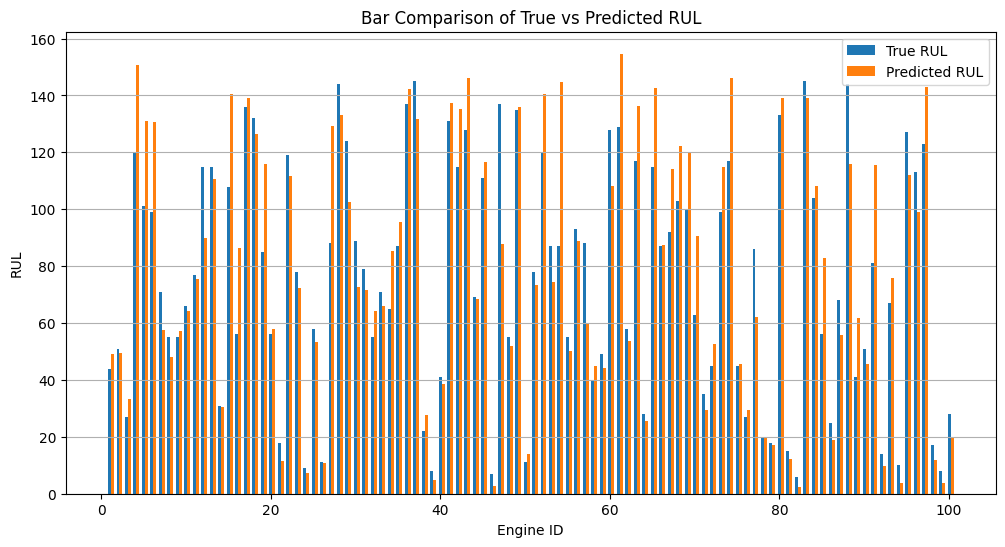

In [33]:
# %%
plt.figure(figsize=(12,6))
width = 0.35

plt.bar(unseen_units, y_unseen, width=width, label="True RUL")
plt.bar(unseen_units + np.array([width]*len(unseen_units)), preds_unseen, width=width, label="Predicted RUL")

plt.title("Bar Comparison of True vs Predicted RUL")
plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.legend()
plt.grid(axis='y')
plt.show()


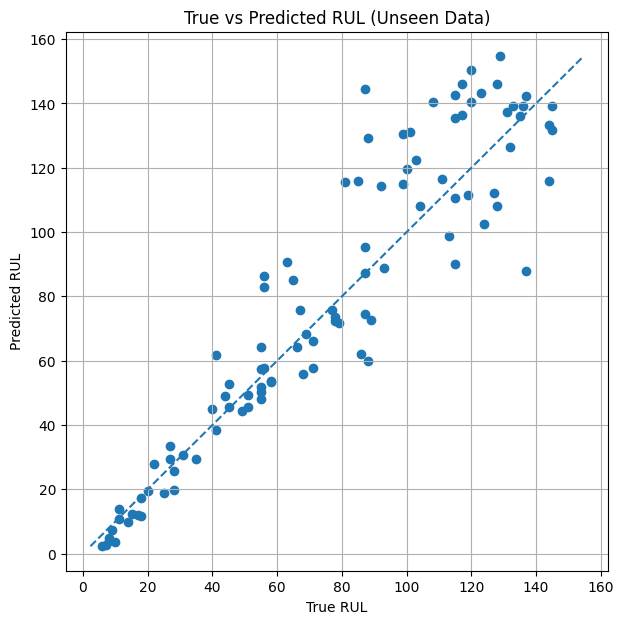

In [34]:
# %%
plt.figure(figsize=(7,7))

plt.scatter(y_unseen, preds_unseen)

plt.title("True vs Predicted RUL (Unseen Data)")
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Optional: Add a diagonal reference line
min_val = min(min(y_unseen), min(preds_unseen))
max_val = max(max(y_unseen), max(preds_unseen))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.show()
